In [1]:
pip install nba-api pandas

  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
Using cached requests-2.32.3-py3-none-any.whl (64 kB)
  Attempting uninstall: requests
    Found existing installation: requests 2.28.1
    Uninstalling requests-2.28.1:
      Successfully uninstalled requests-2.28.1

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: /Users/dileep/opt/anaconda3/envs/data_min/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
def fetch_nba_data(season='2021-22'):
    from nba_api.stats.endpoints import LeagueGameFinder
    
    # Fetch data
    gamefinder = LeagueGameFinder(season_nullable=season)
    games = gamefinder.get_data_frames()[0]
    
    # Print available columns
    print(games.columns)
    return games

# Fetch data and inspect columns
season_data = fetch_nba_data('2021-22')


Index(['SEASON_ID', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_ID',
       'GAME_DATE', 'MATCHUP', 'WL', 'MIN', 'PTS', 'FGM', 'FGA', 'FG_PCT',
       'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB',
       'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PLUS_MINUS'],
      dtype='object')


In [3]:
from nba_api.stats.endpoints import LeagueGameFinder
import pandas as pd

# Fetch game data for a specific season (e.g., 2021-22)
def fetch_nba_data(season='2021-22'):
    # Initialize the LeagueGameFinder object
    gamefinder = LeagueGameFinder(season_nullable=season)
    
    # Get games data
    games = gamefinder.get_data_frames()[0]
    
    # Keep relevant columns
    columns_to_keep = [
        'GAME_ID', 'GAME_DATE', 'MATCHUP', 'TEAM_NAME', 'TEAM_ABBREVIATION', 
        'PTS', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'WL'
    ]
    games = games[columns_to_keep]
    
    return games

# Fetch data
season_data = fetch_nba_data('2021-22')

# Calculate Derived Fields
def process_data(data):
    # Split MATCHUP to determine Home and Away teams
    data['HOME_TEAM'] = data['MATCHUP'].str.split(' ').str[0]
    data['AWAY_TEAM'] = data['MATCHUP'].str.split(' ').str[-1]
    
    # Flag for Home Team Wins (WL column indicates if the team won)
    data['HOME_TEAM_WINS'] = (data['MATCHUP'].str.contains('vs') & (data['WL'] == 'W')).astype(int)
    
    return data

# Process the fetched data
processed_data = process_data(season_data)

# Save to CSV for later use
processed_data.to_csv('nba_season_2021_22_processed.csv', index=False)

# Preview the processed data
print(processed_data.head())


      GAME_ID   GAME_DATE      MATCHUP              TEAM_NAME  \
0  0042100406  2022-06-16  BOS vs. GSW         Boston Celtics   
1  0042100406  2022-06-16    GSW @ BOS  Golden State Warriors   
2  0042100405  2022-06-13  GSW vs. BOS  Golden State Warriors   
3  0042100405  2022-06-13    BOS @ GSW         Boston Celtics   
4  0042100404  2022-06-10  BOS vs. GSW         Boston Celtics   

  TEAM_ABBREVIATION  PTS  REB  AST  STL  BLK  TOV WL HOME_TEAM AWAY_TEAM  \
0               BOS   90   41   27    8    8   22  L       BOS       GSW   
1               GSW  103   44   27   13    7   15  W       GSW       BOS   
2               GSW  104   39   23    9    2    6  W       GSW       BOS   
3               BOS   94   47   18    2    2   18  L       BOS       GSW   
4               BOS   97   42   22    8    6   15  L       BOS       GSW   

   HOME_TEAM_WINS  
0               0  
1               0  
2               1  
3               0  
4               0  


In [19]:
rows, columns = processed_data.shape

print(f"Total rows: {rows}")
print(f"Total columns: {columns}")

Total rows: 4182
Total columns: 15


In [4]:
import pandas as pd

# Load processed data
data = pd.read_csv('nba_season_2021_22_processed.csv')

# 1. Validate HOME_TEAM and AWAY_TEAM
def validate_teams(data):
    unique_home_teams = data['HOME_TEAM'].unique()
    unique_away_teams = data['AWAY_TEAM'].unique()
    print(f"Unique HOME_TEAM values:\n{unique_home_teams}")
    print(f"\nUnique AWAY_TEAM values:\n{unique_away_teams}")

    # Check if there are any unexpected or missing values
    if data['HOME_TEAM'].isnull().sum() > 0 or data['AWAY_TEAM'].isnull().sum() > 0:
        print("Warning: Missing values found in HOME_TEAM or AWAY_TEAM.")
    return data

# 2. Validate HOME_TEAM_WINS
def validate_home_team_wins(data):
    # Calculate HOME_TEAM_WINS from MATCHUP and WL
    data['CALCULATED_HOME_TEAM_WINS'] = (data['MATCHUP'].str.contains('vs') & (data['WL'] == 'W')).astype(int)

    # Compare CALCULATED_HOME_TEAM_WINS with existing HOME_TEAM_WINS
    mismatches = data[data['CALCULATED_HOME_TEAM_WINS'] != data['HOME_TEAM_WINS']]
    if len(mismatches) > 0:
        print(f"Number of mismatches in HOME_TEAM_WINS: {len(mismatches)}")
        print(mismatches[['GAME_ID', 'MATCHUP', 'PTS', 'WL', 'HOME_TEAM_WINS', 'CALCULATED_HOME_TEAM_WINS']].head())
    else:
        print("HOME_TEAM_WINS validation passed: No mismatches found.")

    return data

# Run validations
data = validate_teams(data)
data = validate_home_team_wins(data)


Unique HOME_TEAM values:
['BOS' 'GSW' 'MIA' 'DAL' 'MIL' 'PHX' 'MEM' 'PHI' 'MIN' 'UTA' 'TOR' 'NOP'
 'DEN' 'CHI' 'ATL' 'BKN' 'CLE' 'LAC' 'RGV' 'DEL' 'SAS' 'CHA' 'DET' 'NYK'
 'HOU' 'IND' 'LAL' 'ORL' 'RAP' 'OKC' 'WAS' 'POR' 'SAC' 'ACC' 'MCC' 'TEX'
 'CCG' 'SBL' 'CPS' 'SCW' 'BIR' 'LIN' 'LAK' 'MHU' 'SXF' 'AUS' 'CLC' 'STO'
 'WIS' 'WCB' 'SLC' 'GBO' 'GRG' 'MNE' 'FWN' 'WES' 'OKL' 'IWA' 'GLI' 'DRT'
 'LBN' 'BAR' 'NIQ' 'PAY' 'IAH' 'WAL' 'WOR' 'MXC']

Unique AWAY_TEAM values:
['GSW' 'BOS' 'MIA' 'DAL' 'MIL' 'PHX' 'MEM' 'PHI' 'MIN' 'UTA' 'TOR' 'NOP'
 'CHI' 'DEN' 'ATL' 'BKN' 'CLE' 'LAC' 'DEL' 'RGV' 'CHA' 'SAS' 'IND' 'NYK'
 'POR' 'RAP' 'SAC' 'OKC' 'DET' 'ORL' 'WAS' 'HOU' 'LAL' 'ACC' 'MCC' 'CCG'
 'TEX' 'SBL' 'SCW' 'BIR' 'LIN' 'CPS' 'MNE' 'SXF' 'GBO' 'MHU' 'SLC' 'CLC'
 'AUS' 'WCB' 'STO' 'LAK' 'WIS' 'WES' 'GRG' 'FWN' 'IWA' 'OKL' 'GLI' 'LBN'
 'DRT' 'PAY' 'WAL' 'BAR' 'IAH' 'NIQ' 'WOR' 'MXC']
HOME_TEAM_WINS validation passed: No mismatches found.


In [5]:
#integration of api data and kaggle dataset
import pandas as pd

# Load processed NBA API data
nba_api_data = pd.read_csv('nba_season_2021_22_processed.csv')

# Load Kaggle games dataset
kaggle_games = pd.read_csv('games.csv')  # Load the games.csv file from the Kaggle dataset

# Display columns to ensure proper alignment
print("NBA API Data Columns:", nba_api_data.columns)
print("Kaggle Games Data Columns:", kaggle_games.columns)

# Merge datasets on GAME_ID
def integrate_datasets(api_data, kaggle_data):
    if 'GAME_ID' in api_data.columns and 'GAME_ID' in kaggle_data.columns:
        # Merge on GAME_ID
        merged_data = pd.merge(kaggle_data, api_data, on='GAME_ID', how='outer')
        print(f"Merged dataset has {len(merged_data)} rows and {merged_data.shape[1]} columns.")
        return merged_data
    else:
        print("Error: GAME_ID column is missing in one of the datasets.")
        return None

merged_data = integrate_datasets(nba_api_data, kaggle_games)

# Handle missing values (optional step)
if merged_data is not None:
    merged_data.fillna('Unknown', inplace=True)  # Fill missing values with 'Unknown' or 0
    print("Missing values filled in merged dataset.")

# Save merged dataset
if merged_data is not None:
    merged_data.to_csv('merged_nba_data.csv', index=False)
    print("Merged dataset saved as 'merged_nba_data.csv'.")


NBA API Data Columns: Index(['GAME_ID', 'GAME_DATE', 'MATCHUP', 'TEAM_NAME', 'TEAM_ABBREVIATION',
       'PTS', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'WL', 'HOME_TEAM',
       'AWAY_TEAM', 'HOME_TEAM_WINS'],
      dtype='object')
Kaggle Games Data Columns: Index(['GAME_DATE_EST', 'GAME_ID', 'GAME_STATUS_TEXT', 'HOME_TEAM_ID',
       'VISITOR_TEAM_ID', 'SEASON', 'TEAM_ID_home', 'PTS_home', 'FG_PCT_home',
       'FT_PCT_home', 'FG3_PCT_home', 'AST_home', 'REB_home', 'TEAM_ID_away',
       'PTS_away', 'FG_PCT_away', 'FT_PCT_away', 'FG3_PCT_away', 'AST_away',
       'REB_away', 'HOME_TEAM_WINS'],
      dtype='object')
Merged dataset has 29444 rows and 35 columns.
Missing values filled in merged dataset.
Merged dataset saved as 'merged_nba_data.csv'.


In [6]:

# Preview the merged data
print(merged_data.head())

  GAME_DATE_EST   GAME_ID GAME_STATUS_TEXT  HOME_TEAM_ID VISITOR_TEAM_ID  \
0    2022-12-22  22200477            Final  1610612740.0    1610612759.0   
1    2022-12-22  22200478            Final  1610612762.0    1610612764.0   
2    2022-12-21  22200466            Final  1610612739.0    1610612749.0   
3    2022-12-21  22200467            Final  1610612755.0    1610612765.0   
4    2022-12-21  22200468            Final  1610612737.0    1610612741.0   

   SEASON  TEAM_ID_home PTS_home FG_PCT_home FT_PCT_home  ...      PTS  \
0  2022.0  1610612740.0    126.0       0.484       0.926  ...  Unknown   
1  2022.0  1610612762.0    120.0       0.488       0.952  ...  Unknown   
2  2022.0  1610612739.0    114.0       0.482       0.786  ...  Unknown   
3  2022.0  1610612755.0    113.0       0.441       0.909  ...  Unknown   
4  2022.0  1610612737.0    108.0       0.429         1.0  ...  Unknown   

       REB      AST      STL      BLK      TOV       WL HOME_TEAM AWAY_TEAM  \
0  Unknown  Unknown

In [7]:
# Check for columns with missing values
missing_values = merged_data.isnull().sum()
print("Missing values in merged dataset:")
print(missing_values[missing_values > 0])

# Check a sample of rows with missing GAME_IDs or other key columns
print("\nRows with missing GAME_ID:")
print(merged_data[merged_data['GAME_ID'].isnull()].head())

# Inspect a sample of rows with 'Unknown' data
print("\nSample rows with 'Unknown' values:")
print(merged_data[merged_data.isin(['Unknown']).any(axis=1)].head())


Missing values in merged dataset:
Series([], dtype: int64)

Rows with missing GAME_ID:
Empty DataFrame
Columns: [GAME_DATE_EST, GAME_ID, GAME_STATUS_TEXT, HOME_TEAM_ID, VISITOR_TEAM_ID, SEASON, TEAM_ID_home, PTS_home, FG_PCT_home, FT_PCT_home, FG3_PCT_home, AST_home, REB_home, TEAM_ID_away, PTS_away, FG_PCT_away, FT_PCT_away, FG3_PCT_away, AST_away, REB_away, HOME_TEAM_WINS_x, GAME_DATE, MATCHUP, TEAM_NAME, TEAM_ABBREVIATION, PTS, REB, AST, STL, BLK, TOV, WL, HOME_TEAM, AWAY_TEAM, HOME_TEAM_WINS_y]
Index: []

[0 rows x 35 columns]

Sample rows with 'Unknown' values:
  GAME_DATE_EST   GAME_ID GAME_STATUS_TEXT  HOME_TEAM_ID VISITOR_TEAM_ID  \
0    2022-12-22  22200477            Final  1610612740.0    1610612759.0   
1    2022-12-22  22200478            Final  1610612762.0    1610612764.0   
2    2022-12-21  22200466            Final  1610612739.0    1610612749.0   
3    2022-12-21  22200467            Final  1610612755.0    1610612765.0   
4    2022-12-21  22200468            Final  161

In [8]:
merged_data = pd.merge(kaggle_games, nba_api_data, on='GAME_ID', how='inner')


In [9]:
merged_data.replace('Unknown', pd.NA, inplace=True)
merged_data.fillna({
    'PTS_home': 0, 'PTS_away': 0,  # Fill numeric columns with 0
    'TEAM_NAME': 'Unknown Team',   # Fill categorical columns with a placeholder
}, inplace=True)


In [10]:
merged_data.replace('Unknown', pd.NA, inplace=True)
merged_data.fillna({
    'PTS_home': 0, 'PTS_away': 0,  # Fill numeric columns with 0
    'TEAM_NAME': 'Unknown Team',   # Fill categorical columns with a placeholder
}, inplace=True)


In [11]:
# Save the cleaned dataset
merged_data.to_csv('cleaned_merged_nba_data.csv', index=False)
print("Cleaned merged dataset saved as 'cleaned_merged_nba_data.csv'.")


Cleaned merged dataset saved as 'cleaned_merged_nba_data.csv'.


In [15]:
file = 'cleaned_merged_nba_data.csv'
df = pd.read_csv(file)

print(df.head())

rows, columns = df.shape

print(f"Total rows: {rows}")
print(f"Total columns: {columns}")

  GAME_DATE_EST   GAME_ID GAME_STATUS_TEXT  HOME_TEAM_ID  VISITOR_TEAM_ID  \
0    2022-06-16  42100406            Final    1610612738       1610612744   
1    2022-06-16  42100406            Final    1610612738       1610612744   
2    2022-06-13  42100405            Final    1610612744       1610612738   
3    2022-06-13  42100405            Final    1610612744       1610612738   
4    2022-06-10  42100404            Final    1610612738       1610612744   

   SEASON  TEAM_ID_home  PTS_home  FG_PCT_home  FT_PCT_home  ...  PTS  REB  \
0    2021    1610612738      90.0        0.425        0.917  ...   90   41   
1    2021    1610612738      90.0        0.425        0.917  ...  103   44   
2    2021    1610612744     104.0        0.466        0.867  ...  104   39   
3    2021    1610612744     104.0        0.466        0.867  ...   94   47   
4    2021    1610612738      97.0        0.400        0.737  ...   97   42   

   AST  STL  BLK  TOV  WL  HOME_TEAM  AWAY_TEAM  HOME_TEAM_WINS_y  


In [16]:
file = 'merged_nba_data.csv'
old_df = pd.read_csv(file)

print(old_df.head())

rows, columns = old_df.shape

print(f"Total rows: {rows}")
print(f"Total columns: {columns}")

  GAME_DATE_EST   GAME_ID GAME_STATUS_TEXT  HOME_TEAM_ID VISITOR_TEAM_ID  \
0    2022-12-22  22200477            Final  1610612740.0    1610612759.0   
1    2022-12-22  22200478            Final  1610612762.0    1610612764.0   
2    2022-12-21  22200466            Final  1610612739.0    1610612749.0   
3    2022-12-21  22200467            Final  1610612755.0    1610612765.0   
4    2022-12-21  22200468            Final  1610612737.0    1610612741.0   

   SEASON  TEAM_ID_home PTS_home FG_PCT_home FT_PCT_home  ...      PTS  \
0  2022.0  1610612740.0    126.0       0.484       0.926  ...  Unknown   
1  2022.0  1610612762.0    120.0       0.488       0.952  ...  Unknown   
2  2022.0  1610612739.0    114.0       0.482       0.786  ...  Unknown   
3  2022.0  1610612755.0    113.0       0.441       0.909  ...  Unknown   
4  2022.0  1610612737.0    108.0       0.429         1.0  ...  Unknown   

       REB      AST      STL      BLK      TOV       WL HOME_TEAM AWAY_TEAM  \
0  Unknown  Unknown

/var/folders/nb/7py7v38n0nb2py15v90m86l40000gn/T/ipykernel_90785/1109740671.py:2: DtypeWarning: Columns (3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  old_df = pd.read_csv(file)


In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the cleaned dataset
data = pd.read_csv('cleaned_merged_nba_data.csv')

# Display dataset shape and preview
print(f"Dataset shape: {data.shape}")
print("Preview of the dataset:")
print(data.head())

# 1. Handle Missing Values
def handle_missing_values(data):
    # Fill numeric columns with 0 and categorical columns with 'Unknown'
    numeric_cols = data.select_dtypes(include=['number']).columns
    categorical_cols = data.select_dtypes(include=['object']).columns

    data[numeric_cols] = data[numeric_cols].fillna(0)
    data[categorical_cols] = data[categorical_cols].fillna('Unknown')
    return data

data = handle_missing_values(data)

# 2. Encode Categorical Variables
def encode_categorical_variables(data):
    # Encode categorical columns with one-hot encoding
    categorical_cols = ['HOME_TEAM', 'AWAY_TEAM']  # Adjust based on dataset
    data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)
    return data

data = encode_categorical_variables(data)

# 3. Feature Selection
def feature_selection(data):
    # Drop unnecessary columns
    columns_to_drop = ['GAME_ID', 'GAME_DATE_EST', 'GAME_STATUS_TEXT', 'WL']  # Adjust based on dataset
    data = data.drop(columns=columns_to_drop, errors='ignore')
    return data

data = feature_selection(data)

# 4. Train/Test Split
def split_data(data, target_column='HOME_TEAM_WINS_y'):
    # Separate features and target
    X = data.drop(columns=[target_column])
    y = data[target_column]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = split_data(data)

# Save the preprocessed datasets
X_train.to_csv('X_train.csv', index=False)
X_test.to_csv('X_test.csv', index=False)
y_train.to_csv('y_train.csv', index=False)
y_test.to_csv('y_test.csv', index=False)

# Output message
print("Preprocessing complete. Preprocessed datasets saved as 'X_train.csv', 'X_test.csv', 'y_train.csv', and 'y_test.csv'.")


Dataset shape: (2778, 35)
Preview of the dataset:
  GAME_DATE_EST   GAME_ID GAME_STATUS_TEXT  HOME_TEAM_ID  VISITOR_TEAM_ID  \
0    2022-06-16  42100406            Final    1610612738       1610612744   
1    2022-06-16  42100406            Final    1610612738       1610612744   
2    2022-06-13  42100405            Final    1610612744       1610612738   
3    2022-06-13  42100405            Final    1610612744       1610612738   
4    2022-06-10  42100404            Final    1610612738       1610612744   

   SEASON  TEAM_ID_home  PTS_home  FG_PCT_home  FT_PCT_home  ...  PTS  REB  \
0    2021    1610612738      90.0        0.425        0.917  ...   90   41   
1    2021    1610612738      90.0        0.425        0.917  ...  103   44   
2    2021    1610612744     104.0        0.466        0.867  ...  104   39   
3    2021    1610612744     104.0        0.466        0.867  ...   94   47   
4    2021    1610612738      97.0        0.400        0.737  ...   97   42   

   AST  STL  BLK  

In [25]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Reload datasets
X_train = pd.read_csv('X_train.csv')
X_test = pd.read_csv('X_test.csv')

# Identify non-numeric columns
non_numeric_columns = X_train.select_dtypes(include=['object']).columns
print(f"Non-numeric columns: {non_numeric_columns}")

# 1. Create a shared mapping for each categorical column
def encode_with_shared_mapping(train, test, column):
    # Get unique values from both train and test
    unique_values = pd.concat([train[column], test[column]]).unique()
    
    # Create a mapping dictionary
    mapping = {value: idx for idx, value in enumerate(unique_values)}
    
    # Apply the mapping to train and test
    train[column] = train[column].map(mapping)
    test[column] = test[column].map(mapping)
    return train, test

# Apply shared mapping for all non-numeric columns
for col in non_numeric_columns:
    X_train, X_test = encode_with_shared_mapping(X_train, X_test, col)

# Save the fixed datasets
X_train.to_csv('X_train_fixed.csv', index=False)
X_test.to_csv('X_test_fixed.csv', index=False)

print("\nAll non-numeric columns have been encoded with a shared mapping. Datasets are ready for model training.")


Non-numeric columns: Index(['GAME_DATE', 'MATCHUP', 'TEAM_NAME', 'TEAM_ABBREVIATION'], dtype='object')

All non-numeric columns have been encoded with a shared mapping. Datasets are ready for model training.


In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd

# Load the fixed datasets
X_train = pd.read_csv('X_train_fixed.csv')
X_test = pd.read_csv('X_test_fixed.csv')
y_train = pd.read_csv('y_train.csv').squeeze()  # Ensure y_train is a Series
y_test = pd.read_csv('y_test.csv').squeeze()    # Ensure y_test is a Series

# Train Logistic Regression Model
print("Training Logistic Regression...")
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)

# Make Predictions
y_pred = model.predict(X_test)

# Evaluate the Model
print("\nModel Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Training Logistic Regression...

Model Performance:
Accuracy: 0.72

Classification Report:
              precision    recall  f1-score   support

           0       0.72      1.00      0.84       403
           1       0.00      0.00      0.00       153

    accuracy                           0.72       556
   macro avg       0.36      0.50      0.42       556
weighted avg       0.53      0.72      0.61       556


Confusion Matrix:
[[403   0]
 [153   0]]


/Users/dileep/opt/anaconda3/envs/data_min/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dileep/opt/anaconda3/envs/data_min/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dileep/opt/anaconda3/envs/data_min/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

In [30]:
print(y_train.value_counts())


0    1607
1     615
Name: HOME_TEAM_WINS_y, dtype: int64


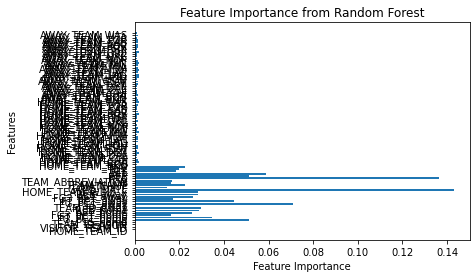

In [31]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

# Train a random forest model to check feature importance
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Plot feature importance
importance = rf_model.feature_importances_
plt.barh(X_train.columns, importance)
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance from Random Forest")
plt.show()


In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

rf_model = RandomForestClassifier(class_weight="balanced", random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

print("\nRandom Forest Performance:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))



Random Forest Performance:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       403
           1       0.96      0.90      0.93       153

    accuracy                           0.96       556
   macro avg       0.96      0.94      0.95       556
weighted avg       0.96      0.96      0.96       556


Confusion Matrix:
[[398   5]
 [ 16 137]]


In [33]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]),
                           random_state=42)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

print("\nXGBoost Performance:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))



XGBoost Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       403
           1       0.99      1.00      0.99       153

    accuracy                           1.00       556
   macro avg       0.99      1.00      1.00       556
weighted avg       1.00      1.00      1.00       556


Confusion Matrix:
[[401   2]
 [  0 153]]


In [34]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("After SMOTE:")
print(y_train_smote.value_counts())


After SMOTE:
1    1607
0    1607
Name: HOME_TEAM_WINS_y, dtype: int64


In [35]:
from sklearn.metrics import roc_auc_score

# Calculate ROC-AUC
y_prob = rf_model.predict_proba(X_test)[:, 1]  # Use probabilities for class 1
roc_auc = roc_auc_score(y_test, y_prob)
print(f"ROC-AUC Score: {roc_auc:.2f}")


ROC-AUC Score: 0.99


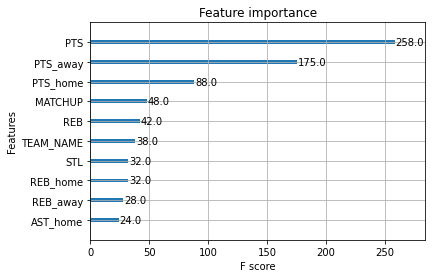

<Figure size 720x576 with 0 Axes>

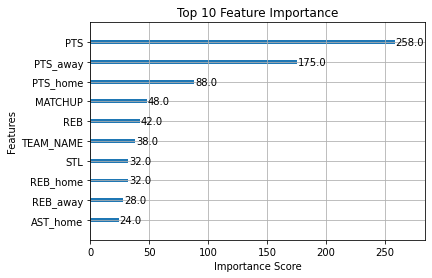

In [46]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

# Plot feature importance
plot_importance(xgb_model, max_num_features=10)
plt.show()

plt.figure(figsize=(10, 8))
plot_importance(xgb_model, max_num_features=10, importance_type='weight', title="Top 10 Feature Importance")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()

In [42]:
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


y_pred = xgb_model.predict(X_test)  # Replace 'xgb_model' with your model if different

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a PDF report
with PdfPages('model_report.pdf') as pdf:
    # Add Feature Importance
    plt.figure(figsize=(10, 8))
    plot_importance(xgb_model, max_num_features=10, importance_type='weight', title="Top 10 Feature Importance")
    pdf.savefig()  # Save the figure to the PDF
    plt.close()
    
    # Add Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    pdf.savefig()
    plt.close()
    
    y_prob = xgb_model.predict_proba(X_test)[:, 1]  # Replace 'xgb_model' with your model if different

    # Calculate ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    # Add ROC Curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    pdf.savefig()
    plt.close()
    
print("Model report saved as 'model_report.pdf'.")


Model report saved as 'model_report.pdf'.


<Figure size 720x576 with 0 Axes>